In [214]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.stats as stats

import fitsio
import xlens

import tables_io
import h5py
from astropy.table import Table
from astropy.stats import biweight_location, biweight_scale
from scipy.stats import sigmaclip
from astropy.io import fits
from matplotlib import cm
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import make_interp_spline
import emcee


import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
from clmm.support.sampler import fitters
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times"],
    "figure.labelsize": 14,
    "mathtext.fontset": 'stix',
    "font.family": "STIXGeneral",
    "font.size": 14,
    "figure.titlesize": 14
})

In [2]:
%config InlineBackend.figure_format='retina'

In [222]:
from chainconsumer import Chain, ChainConsumer, make_sample

In [172]:
arcsec = 1 / 60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
Daz1z2 = lambda z1, z2 : 1/(1+z2)*(chi_dl(z2) - chi_dl(z1))
# beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]
beta_s = lambda zl, zs : 0 if zs < zl else Daz1z2(zl, zs)/Da(zs) * Da(1e3)/Daz1z2(zl, 1e3)

In [4]:
pdir = os.getenv("PSCRATCH")
hdir = os.getenv("HOME")

In [5]:
pscratch= "/pscratch/sd/x/xiangchl/"
xli_dir = os.path.join(
    pscratch,
    "data/DP1"
)

In [6]:
edfs_anacal = tables_io.read(f'{xli_dir}/rail_data/data_edfs_with_mag.hdf5',
                             tType = "astropyTable"
                            )
ecdfs_anacal = Table.read(f'{xli_dir}/catalogs/anacal_catalog_ecdfs.fits')

In [86]:
edfs_redshifts = tables_io.read(f'{xli_dir}/rail_data/data_edfs_redshift.hdf5',
                                tType = "astropyTable"
                               )

In [87]:
edfs_pzs = tables_io.read(f'{xli_dir}/rail_data/data_edfs_redshift_pdfs.fits',
                          tType = "astropyTable"
                         )

In [88]:
with fits.open(f'{xli_dir}/rail_data/data_edfs_redshift_pdfs.fits') as hdul:
    edfs_pzs = hdul[0].data
    edfs_pzs_meta = hdul[0].header

In [89]:
edfs_anacal['zbest'] = edfs_redshifts['zbest']

In [113]:
ecdfs_anacal['index'] = np.arange(len(ecdfs_anacal))
edfs_anacal['index'] = np.arange(len(edfs_anacal))

In [114]:
def fast_bootstrap_mean(data, n_resamples=2000, ci_level=0.95):
    n = len(data)
    means = np.empty(n_resamples)
    for i in range(n_resamples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
    alpha = 1.0 - ci_level
    lower = np.percentile(means, 100 * alpha / 2)
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return np.array([lower, upper])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95, verbose=False):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) 
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        if verbose: print(np.sum(ndx_filt))
        R_correction = np.mean(sr)
        ta = np.mean(sample_t)/R_correction2
        xa = np.mean(sample_x)/R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level, n_resamples=500)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level, n_resamples=500)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level, n_resamples=500)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err

(-1.0, 2.0)

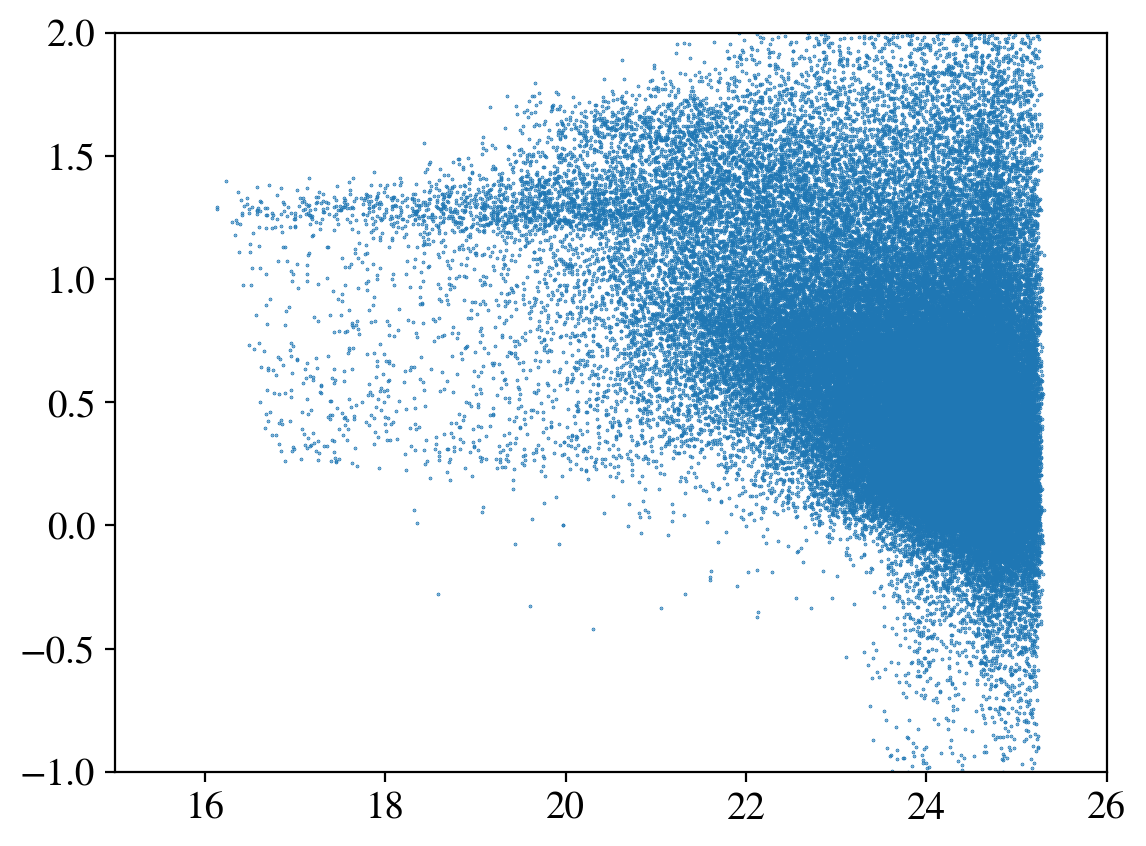

In [115]:
plt.scatter(edfs_anacal['i_mag_gauss2'], edfs_anacal['g_mag_gauss2'] - edfs_anacal['r_mag_gauss2'], s=0.1)
plt.xlim(15, 26)
plt.ylim(-1, 2)

In [116]:
mag_cuts = [27.5, 27.5, 24.5, 27.5, 27.5, 27.5]

def get_mask(df, z_cut, SG_cut=0.1, mag_cuts=mag_cuts):
    msk = (
        (df["u_mag_gauss2"] < mag_cuts[0]) & 
        (df["g_mag_gauss2"] < mag_cuts[1]) & 
        (df["r_mag_gauss2"] < mag_cuts[2]) &  # magnitude cut
        (df["i_mag_gauss2"] < mag_cuts[3]) & 
        (df["z_mag_gauss2"] < mag_cuts[4]) & 
        (df["y_mag_gauss2"] < mag_cuts[5]) &
        ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > SG_cut) & # resolution cut
        (df["zbest"] > z_cut)   # redshift cut
    )
    masked_df = df[msk]
    return masked_df, msk

def calibrate_shapes(df2):
    c0 = 50.0
    weights = {
        "g": 0.10110928,
        "r": 0.290752, 
        "i": 0.51740466 , 
        "z": 0.09073406,
    }
    m22c = np.zeros(len(df2))
    dm22c_dg1 = np.zeros(len(df2))
    m22s = np.zeros(len(df2))
    dm22s_dg2 = np.zeros(len(df2))
    m00 = np.zeros(len(df2))
    dm00_dg1 = np.zeros(len(df2))
    dm00_dg2 = np.zeros(len(df2))
    for band in ["g", "r", "i", "z"]:
        w = weights[band]
        m22c = m22c + df2[f"{band}_fpfs1_m22c"] * w
        m22s = m22s + df2[f"{band}_fpfs1_m22s"] * w
        m00 = m00 + df2[f"{band}_fpfs1_m00"] * w
        dm22c_dg1 = dm22c_dg1 + df2[f"{band}_fpfs1_dm22c_dg1"] * w
        dm22s_dg2 = dm22s_dg2 + df2[f"{band}_fpfs1_dm22s_dg2"] * w
        dm00_dg1 = dm00_dg1 + df2[f"{band}_fpfs1_dm00_dg1"] * w
        dm00_dg2 = dm00_dg2 + df2[f"{band}_fpfs1_dm00_dg2"] * w
    e1 = m22c / (m00 + c0) * df2["wsel"]
    e2 = m22s / (m00 + c0) * df2["wsel"]
    de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
    de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
    res = (
        de1_dg1 * df2["wsel"] + df2["dwsel_dg1"]* m22c / (m00 + c0) +
        de2_dg2 * df2["wsel"] + df2["dwsel_dg2"]* m22s / (m00 + c0)
    ) / 2.0

    return e1, e2, res


def add_cluster_info(df, cluster_info):
    source_phi = np.arctan2(df['dec'] - cluster_info[1],
                         (cluster_info[0] - df['ra'])*np.cos(np.deg2rad(cluster_info[1])))
    ang_dist = np.sqrt(((df['ra'] - cluster_info[0]) * np.cos(np.deg2rad(cluster_info[1])))**2 + (df['dec'] - cluster_info[1])**2)
    sky_distance = cosmo.eval_da(cluster_info[2]) * ang_dist * (np.pi/180)

    df['source_phi'] = source_phi
    df['ang_dist'] = ang_dist
    df['sky_dist'] = sky_distance

    return source_phi, ang_dist, sky_distance

In [346]:
# RA, DEC, z
cluster_info = (59.487317, -49.000349, 0.7)
# cluster_info = (59.4727825, -48.995145, 0.3816) # EDFS-ACT
# cluster_info = (59.48731586, -49.00034946, 0.6922) # EDFS_eRASS
# cluster_info = (59.93045557, -48.66165602, 0.3773) #EDFS_eRASS
# cluster_info = (58.45943885, -48.41679742, 0.1364) #EDFS_eRASS

# cluster_info = (59.4727825,	-48.995145, 0.38) # EDFS ACT


# cluster_info = (59.015646, -48.652003, 0.2826488316) # EDFS_DES (USABLE)
cluster_info = (59.482185, -48.998922, 0.6916004419) # EDFS_DES (GOOD)
# cluster_info = (58.762619, -48.24686, 0.331141293) # EDFS_DES
# cluster_info = (58.753116, -49.201968, 0.359061867) # EDFS_DES
# cluster_info = (59.035835, -48.587113, 0.6882526875) # EDFS_DES (USABLE)

_ = add_cluster_info(edfs_anacal, cluster_info)

(-1.0, 2.5)

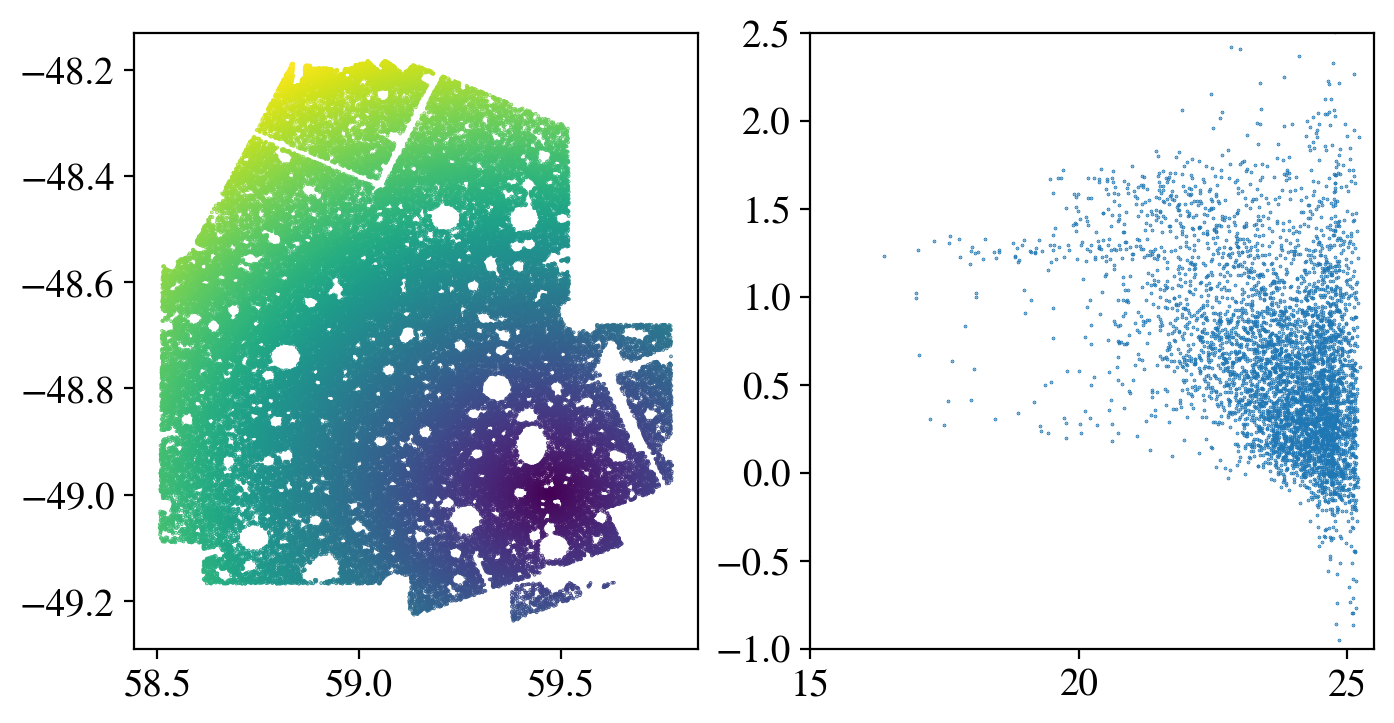

In [345]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].scatter(edfs_anacal['ra'],
            edfs_anacal['dec'],
            s=0.1,
            c=edfs_anacal['ang_dist'])

centered_cut = edfs_anacal['sky_dist'] < 2
kax = ax[1].scatter(edfs_anacal['i_mag_gauss2'][centered_cut],
              edfs_anacal['g_mag_gauss2'][centered_cut] - edfs_anacal['r_mag_gauss2'][centered_cut],
              s=0.1)
ax[1].set_xlim(15, 25.5)
ax[1].set_ylim(-1, 2.5)

(-1.0, 2.5)

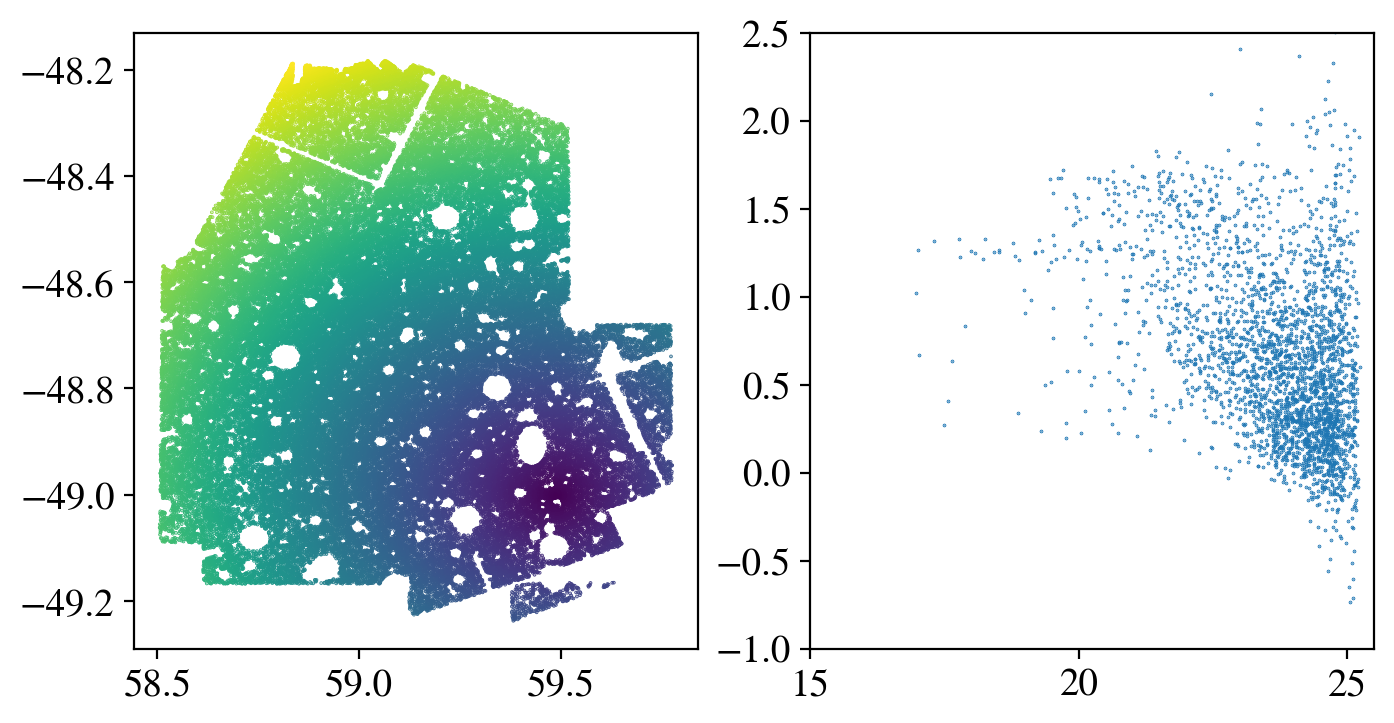

In [306]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].scatter(edfs_anacal['ra'],
            edfs_anacal['dec'],
            s=0.1,
            c=edfs_anacal['ang_dist'])

centered_cut = edfs_anacal['sky_dist'] < 2
ax[1].scatter(edfs_anacal['i_mag_gauss2'][centered_cut],
              edfs_anacal['g_mag_gauss2'][centered_cut] - edfs_anacal['r_mag_gauss2'][centered_cut],
              s=0.1)
ax[1].set_xlim(15, 25.5)
ax[1].set_ylim(-1, 2.5)

In [356]:
mag_cuts = np.array([27.5, 27.5, 24.5, 27.5, 27.5, 27.5])

# _, zmask = get_mask(edfs_anacal, .4, mag_cuts=mag_cuts)
# add_mask = edfs_anacal['zbest'] < .7
# final_mask = zmask & add_mask
# masked_df = edfs_anacal[final_mask]

masked_df, _ = get_mask(edfs_anacal, 1.2, mag_cuts=mag_cuts)

e1, e2, res = calibrate_shapes(masked_df)
masked_df['response'] = res

In [357]:
trial_shear = e1 + 1.j*e2
cl_shear = trial_shear * -1*np.exp(-2j*masked_df['source_phi'])

In [358]:
bins_mpc = clmm.make_bins(0.2,9,nbins=7, method='evenlog10width')
# bins_mpc = clmm.make_bins(0.3,7,nbins=5, method='evenlog10width')

bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, masked_df['sky_dist'],
                                 bins_mpc, res, ci_level=.68, verbose=False)

436


Text(0.5, 0.98, 'EDFS DES Cluster at z=0.69')

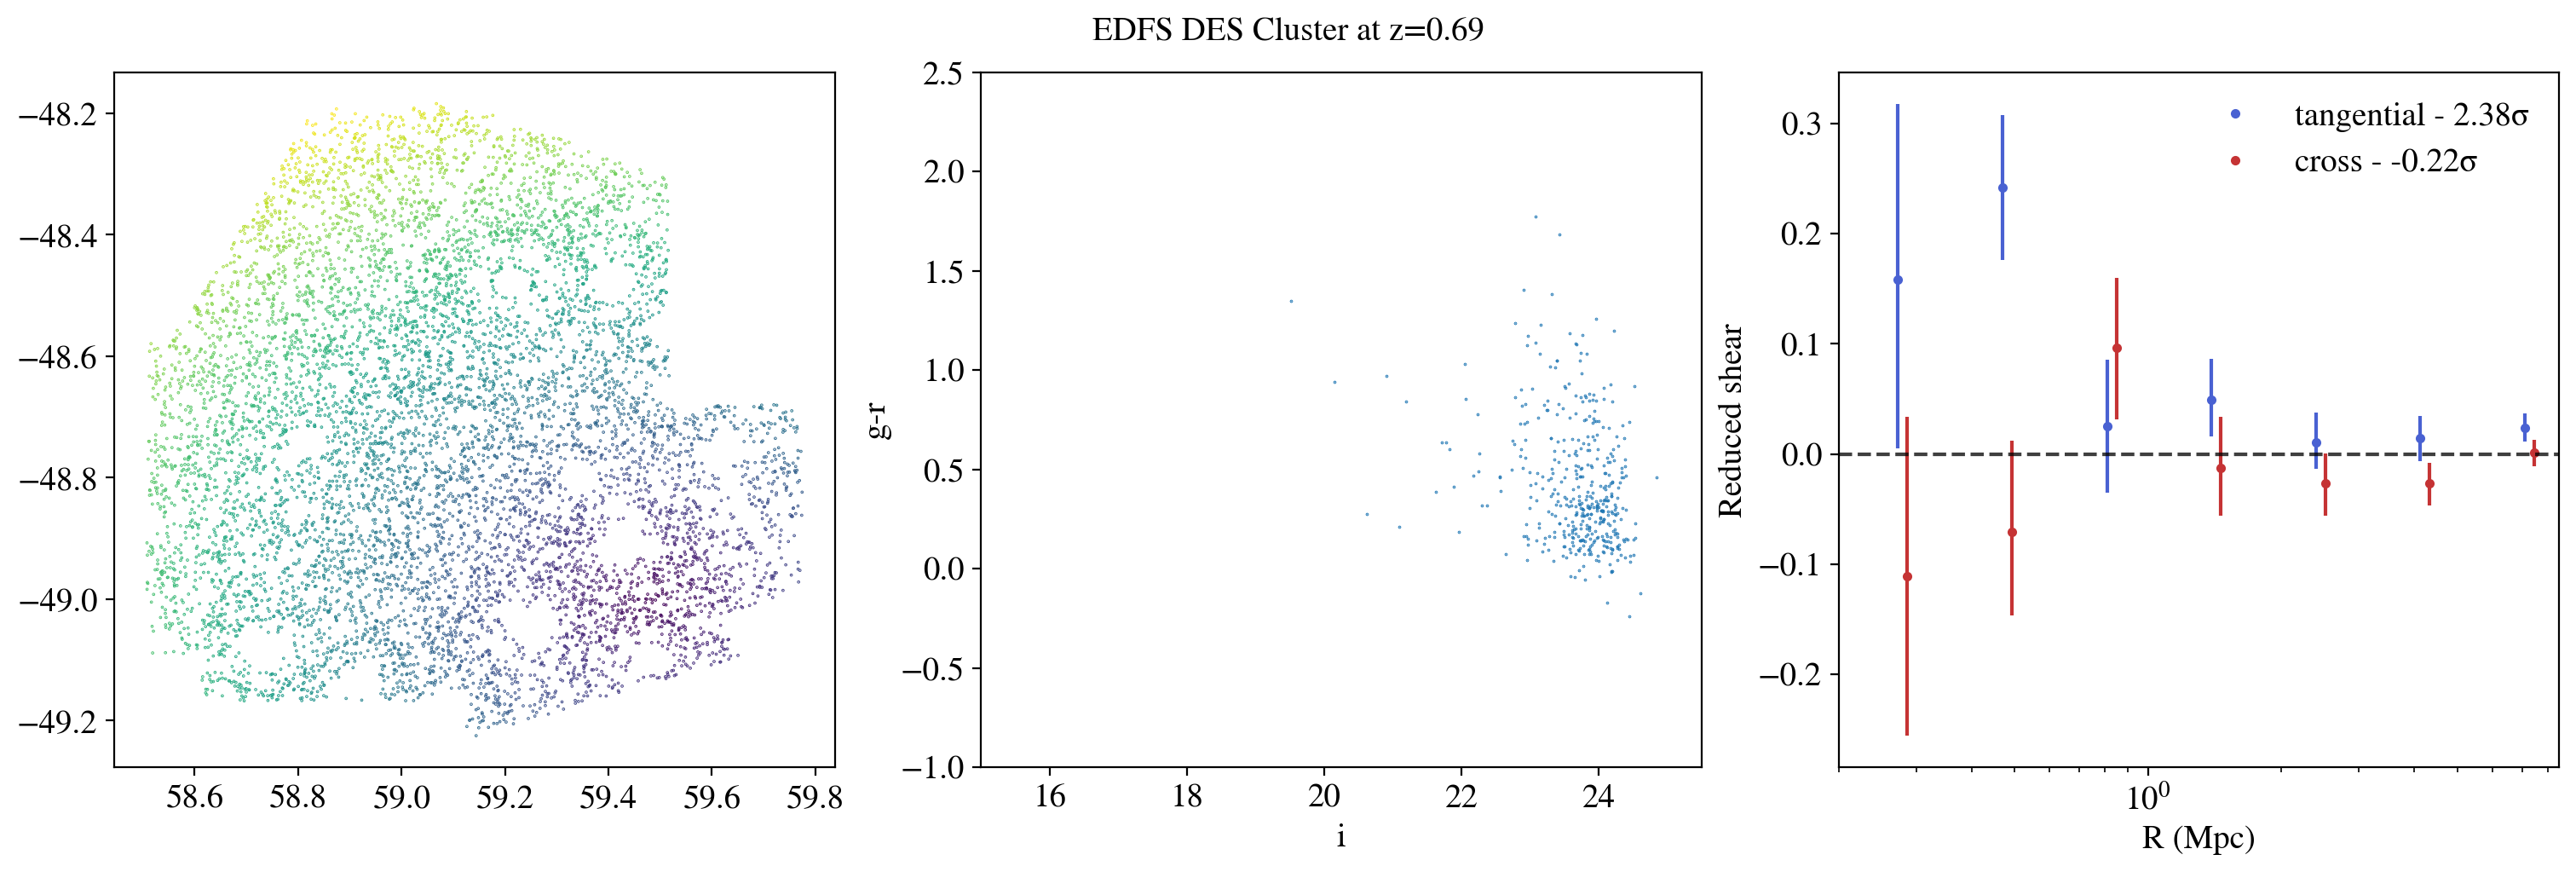

In [359]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), layout='constrained')

ax[0].scatter(masked_df['ra'],
            masked_df['dec'],
            s=0.1,
            c=masked_df['ang_dist'])

centered_cut = masked_df['sky_dist'] < 2.5
print(np.sum(centered_cut))
ax[1].scatter(masked_df['i_mag_gauss2'][centered_cut],
              masked_df['g_mag_gauss2'][centered_cut] - masked_df['r_mag_gauss2'][centered_cut],
              s=0.1)
ax[1].set_xlabel("i")
ax[1].set_ylabel("g-r")
ax[1].set_xlim(15, 25.5)
ax[1].set_ylim(-1, 2.5)

chi2_t = np.sum(shear_cl[0] ** 2.0 / ((shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0) ** 2.0)
chi2_x = np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)

sigma_t = stats.norm.isf(stats.chi2.sf(chi2_t, len(bins_mpc)))
sigma_x = stats.norm.isf(stats.chi2.sf(chi2_x, len(bins_mpc)))

cmap = cm.coolwarm
ax[2].plot(bin_mids, shear_cl[0], '.', label=f'tangential - {sigma_t:0.2f}σ', color=cmap(.05))
ax[2].vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

ax[2].plot(1.05*bin_mids, shear_cl[1], '.', label=f'cross - {sigma_x:0.2f}σ', color=cmap(.95))
ax[2].vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
ax[2].axhline(0, ls='--', color='k', alpha=.5)


ax[2].semilogx()
ax[2].axhline(0, ls='--', color='k', alpha=.5)
ax[2].set_xlim([0.2,8.5])
# ax[2].set_ylim([-0.1,0.15])
ax[2].set_ylabel("Reduced shear")
ax[2].set_xlabel("R (Mpc)")
ax[2].legend(frameon=False, loc='upper right')
z = cluster_info[2]
fig.suptitle(f"EDFS DES Cluster at {z=:0.2f}")

#### N(z) Conversion

In [360]:
test_zs = np.arange(0, 5.01, 0.01)
response_stacked_nz = np.zeros(len(test_zs))

In [361]:
nz_ndxs = masked_df['index']
response_stacked_nz = np.dot(masked_df['response'], edfs_pzs[nz_ndxs])
nz_normalization = integrate.trapezoid(response_stacked_nz, test_zs)
normalized_nz = response_stacked_nz/nz_normalization

In [362]:
full_nz = np.sum(edfs_pzs, axis=0)
full_norm = integrate.trapezoid(full_nz, test_zs)
full_norm_nz = full_nz/full_norm

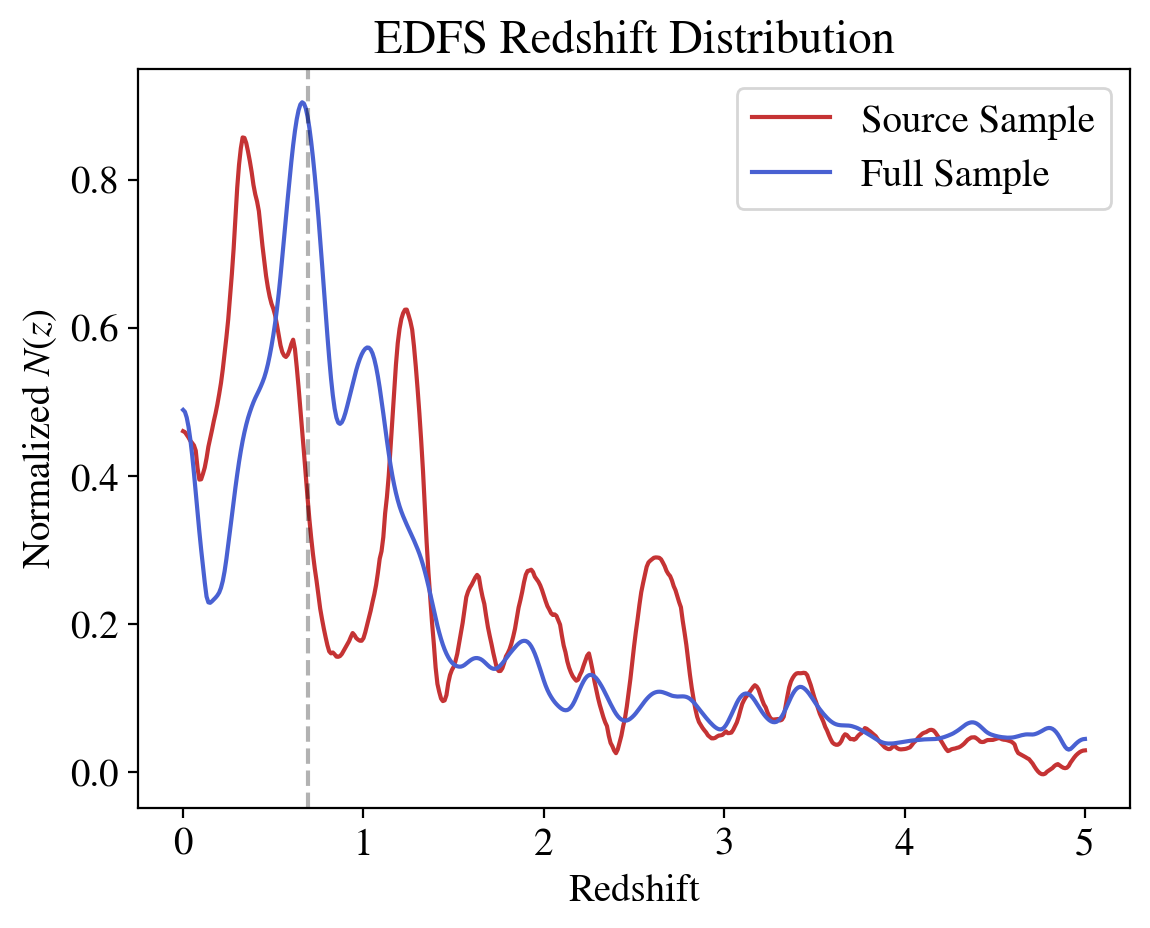

In [363]:
cmap = cm.coolwarm
plt.plot(test_zs, normalized_nz, '-', label='Source Sample', color=cmap(0.95))
plt.plot(test_zs, full_norm_nz, '-', label='Full Sample', color=cmap(0.05))
plt.xlabel("Redshift")
plt.legend()
plt.ylabel("Normalized $N(z)$")
plt.title("EDFS Redshift Distribution")
plt.axvline(cluster_info[2], ls='--', color='k', alpha=0.3)

In [364]:
def get_beta_betasqr_pdf(nz, beta_s, beta_sqr, zs):
    normalization = integrate.trapezoid(nz, zs)
    avg_beta_s = integrate.trapezoid(beta_s * nz, zs) / normalization
    avg_beta_s_sqr = integrate.trapezoid(beta_sqr * nz, zs) / normalization
    return avg_beta_s, avg_beta_s_sqr

In [365]:
test_xs = np.linspace(0, 5, 501)

In [366]:
cluster_info[2]

0.6916004419

In [367]:
beta_s_vals = np.array([beta_s(cluster_info[2], xx) for xx in test_xs])
beta_sqr_vals = beta_s_vals**2

In [368]:
cluster_beta_s, cluster_beta_s_sqr = get_beta_betasqr_pdf(normalized_nz, beta_s_vals, beta_sqr_vals, test_xs)

In [369]:
cluster_beta_s

np.float64(0.32995697197991125)

In [315]:
cluster_beta_s_sqr

np.float64(0.14755934552444414)

#### CLMM Mass Fit

In [317]:
def fit_mass(predict_function, fit_data, **kwargs):
    popt, pcov = fitters["curve_fit"](
        predict_function,
        fit_data["radius"],
        fit_data["gt"],
        fit_data["gt_err"],
        **kwargs,
    )
    return {
        "vals": popt,
        "err": np.sqrt(np.diag(pcov)),
        "cov": pcov,
    }


def fixed_concentration_fit(profile, beta, betasqr, cdelta, halo_profile="nfw"):
    fn = lambda radius, logm: clmm.compute_reduced_tangential_shear(
                r_proj=radius,  # Radial component of the profile
                mdelta=10**logm,  # Mass of the cluster [M_sun]
                cdelta=cdelta,  # Concentration of the cluster
                z_cluster=cluster_info[2],  # Redshift of the cluster
                z_src=(beta, betasqr),  # tuple of (bs_mean, bs2_mean)
                z_src_info="beta",
                approx="order2",
                cosmo=cosmo,
                delta_mdef=500,
                massdef="critical",
                halo_profile_model=halo_profile
                )

    _bounds = [10.0, 17.0]
    mass_fit = fit_mass(fn, profile.profile, bounds=_bounds)
    return fn, mass_fit
    
def mcmc_fit_1d(profile, fn, init, nwalkers=32, nsteps=100):
    fit_data = profile.profile
    def log_prob(pars):

        if pars[0] < 10:
            return -np.inf
        if pars[0] > 16:
            return -np.inf

        model = fn(fit_data["radius"], *pars)
        diff = model - fit_data["gt"]
        sig = fit_data["gt_err"]
        lnlike = -0.5 * diff**2 / sig**2

        return lnlike.sum()

    sampler = emcee.EnsembleSampler(nwalkers, 1, log_prob)

    p0 = np.random.normal(init["vals"], init["err"] * 0.3, (nwalkers, 1))
    p0[p0 < 0] *= -1
    sampler.run_mcmc(p0, nsteps, progress=True)
    return {
        "mcmc_chain": sampler.get_chain().flatten(),
        "mcmc_loglike": sampler.get_log_prob().flatten(),
    }


In [318]:
galcat = GCData()
galcat['ra'] = masked_df['ra']
galcat['dec'] = masked_df['dec']
galcat['e1'] = e1
galcat['e2'] = e2
galcat['id'] = np.arange(len(masked_df))
galcat['z'] = masked_df['zbest']

In [319]:
ra_bcg = cluster_info[0]
dec_bcg = cluster_info[1]

cluster_id = "EDFS z0.7"
# gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, cluster_info[2], galcat)

gc_object1.compute_tangential_and_cross_components(add=True);

# bins_mpc = np.array([0.3, 0.7       , 1.06495522, 1.62018517, 2.46489237, 3.75    , 5, 6 ])
bins_mpc = clmm.make_bins(0.2,9,nbins=7, method='evenlog10width')
bins_mpc = clmm.make_bins(0.3,7,nbins=5, method='evenlog10width')


gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, 
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

In [320]:
profile = gc_object1.profile

Text(0.5, 1.0, 'Anacal - 0.30 Mpc to 7.00 Mpc')

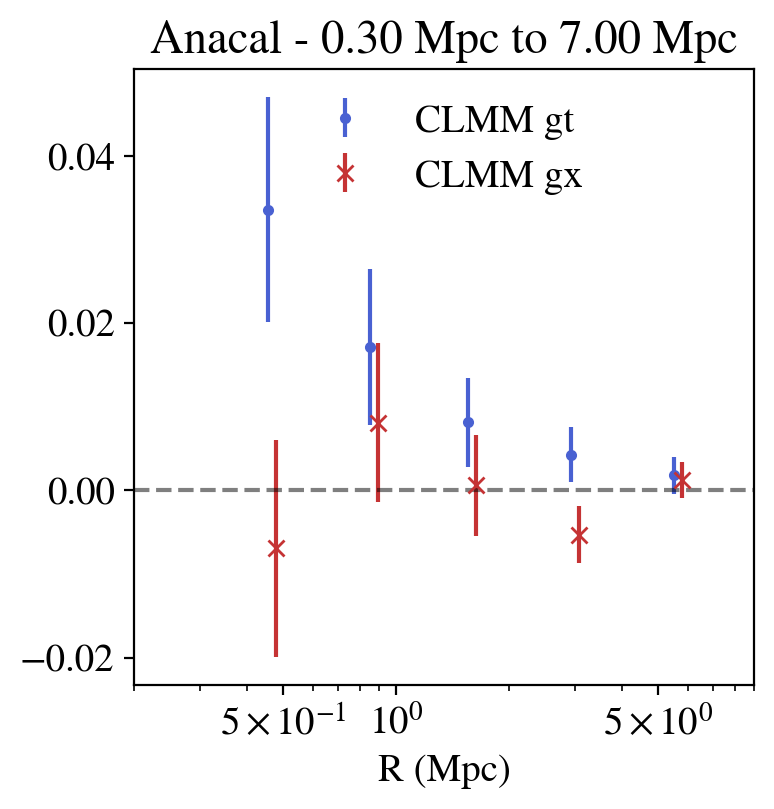

In [321]:
fig, ax = plt.subplots(1, figsize=(4,4))
cmap = cm.coolwarm
cmap2 = cm.PiYG

ax.errorbar(profile['radius'], profile['gt'], profile['gt_err'], 
             ls='', marker='.', color=cmap(0.05), label='CLMM gt')
ax.errorbar(profile['radius']*1.05, profile['gx'], profile['gx_err'], 
             ls='', marker='x', color=cmap(0.95), label='CLMM gx')

ax.semilogx()
ax.set_xlim(0.2, 9)
ax.axhline(0, ls='--', color='k', alpha=.5)
ax.set_xticks([0.5, 1, 5], [r'$5\times 10^{-1}$', '$10^0$', r'$5\times 10^0$'])
ax.set_xlabel("R (Mpc)")
# ax.axvline(0.7, ls='-', color='k', alpha=0.5)
# ax.axvline(3.75, ls='-', color='k', alpha=0.5)
ax.legend(frameon=False, loc='upper center', ncols=1)

ax.set_title(f"Anacal - {profile['radius_min'][0]:0.2f} Mpc to {profile['radius_max'][-1]:0.2f} Mpc")

In [322]:
from colossus.cosmology import cosmology
from colossus.halo import mass_so, mass_defs, mass_adv, concentration
cosmology.setCosmology('planck18');

M500 = 32.75 * 1e13
# c500 = 2.26

# M200c, R200c, c200c = mass_defs.changeMassDefinition(M500, c500, 0.22, '500c', '200c')
# print(M200c)
# print(c200c)
# logM = np.log10(M200c)
logM = np.log10(M500)
print(logM)
# c_fit = c200c
# c_fit = c500

14.515211304327801


In [329]:
low_logM = np.log10(27.67 * 1e13)
high_logM = np.log10(38.84 * 1e13)

In [325]:
fn, init = fixed_concentration_fit(gc_object1, cluster_beta_s, cluster_beta_s_sqr,
                                   2.26, "nfw")

In [326]:
mcmc_results = mcmc_fit_1d(gc_object1, fn, init, nwalkers=32, nsteps=100)
np_mcmc = np.zeros((32*100, 2))
np_mcmc[:, 0] = mcmc_results['mcmc_chain']
np_mcmc[:, 1] = mcmc_results['mcmc_loglike']

100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


Text(0, 0.5, 'Normalized Counts')

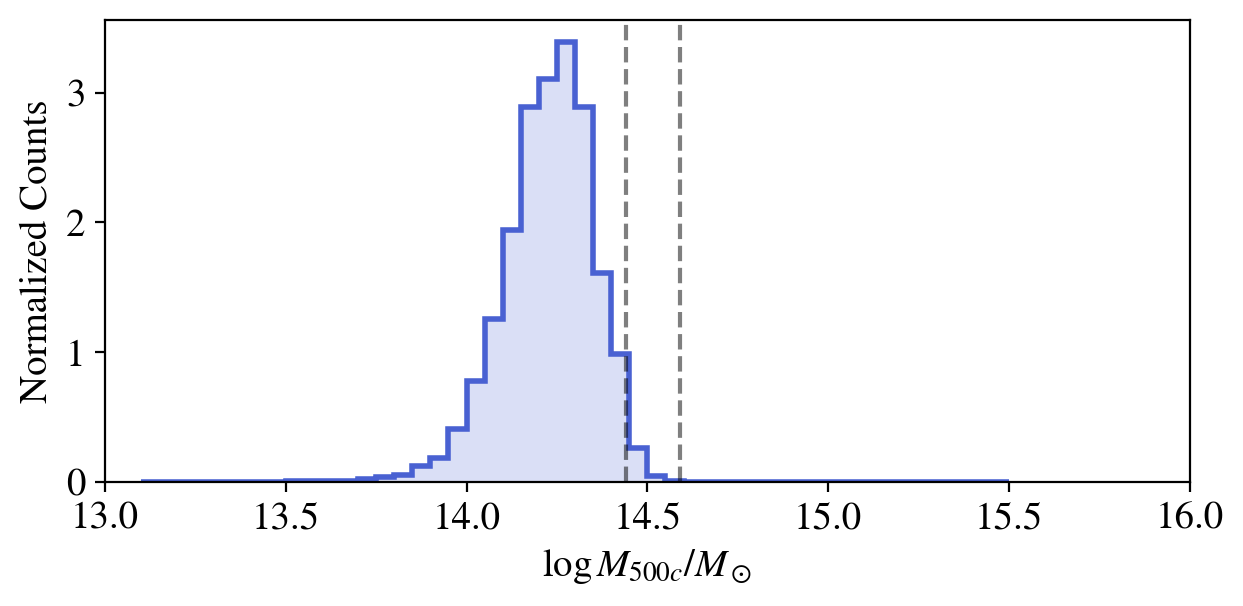

In [331]:
fig = plt.figure(figsize=(7,3))

cmap = cm.coolwarm


mass_bins = np.arange(13.1, 15.5, 0.05)

chain = np_mcmc[:,0]
ll = np_mcmc[:,1]
fin_filt = np.isfinite(ll)
chain = chain[fin_filt]
ll = ll[fin_filt]

plt.hist(chain, bins=mass_bins, weights=np.exp(ll), density=True, linewidth=2,
         histtype='step', color=cmap(0.05), linestyle='-')
plt.hist(chain, bins=mass_bins, weights=np.exp(ll), density=True, linewidth=2,
         histtype='stepfilled', color=cmap(0.05), linestyle='-', alpha=0.2)

plt.xlim(13, 16)
# plt.legend(frameon=False)
plt.xlabel(r"$\log{M_{500c}/M_\odot}$")
# plt.axvline(logM, ls='--', color='k', alpha=0.5)
plt.axvline(low_logM, ls='--', color='k', alpha=0.5)
plt.axvline(high_logM, ls='--', color='k', alpha=0.5)
plt.ylabel("Normalized Counts")